##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [2]:
!pip install -q mediapipe
print("hello world")

hello world



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [3]:
!curl -o face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3670k  100 3670k    0     0  10.2M      0 --:--:-- --:--:-- --:--:-- 10.3M


## Visualization utilities

In [4]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

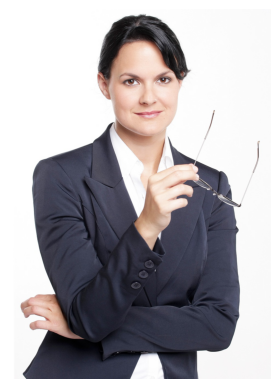

In [5]:
# System command to download the image using curl
# -s makes it silent (like -q)
# -o specifies the output filename
!curl -s -o image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

# Import necessary libraries
import cv2
import matplotlib.pyplot as plt
# import numpy as np # Used for checking if image loaded correctly

# Read the image using OpenCV
img = cv2.imread("image.png")


# --- Display Logic for Local Jupyter ---
if img is None:
    print("Error: Could not load the image. Check if the file was downloaded correctly.")
else:
    # OpenCV reads image in BGR format, Matplotlib expects RGB.
    # We must convert the color space.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off') # Hides the axis ticks and labels
    plt.show()

In [6]:
# !curl -q -o image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

# import cv2
# from google.colab.patches import cv2_imshow

# img = cv2.imread("image.png")
# cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [7]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


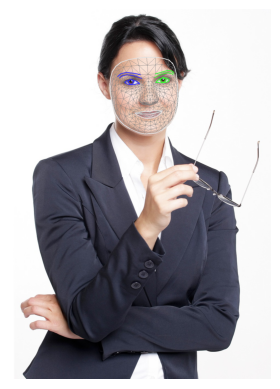

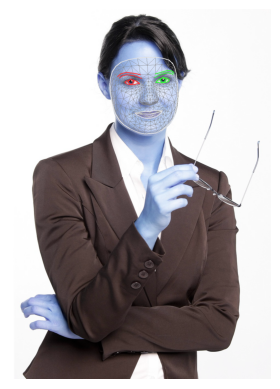

In [8]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.imshow(annotated_image)
plt.axis('off') # Hides the axis ticks and labels
plt.show()
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.axis('off') # Hides the axis ticks and labels
plt.show()

In [9]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
# The drawing utility is now available directly under the vision module in Tasks
from mediapipe.tasks.python.components import drawing_utils as mp_drawing

# --- Helper Function to draw landmarks (MODERN VERSION) ---
def draw_landmarks_on_image(rgb_image, detection_result):
    """Draws landmarks on the RGB image using the modern MediaPipe Tasks drawing utilities."""
    annotated_image = np.copy(rgb_image)
    
    # Check if any faces were detected
    if not detection_result.face_landmarks:
        return rgb_image

    for face_landmarks in detection_result.face_landmarks:
        
        # 1. Draw the connection lines (Tesselation)
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            # Use the default FaceLandmarker connection style
            connections=mp.solutions.face_landmarker.FACELANDMARKER_TESSELATION, 
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1)
        )
        
        # 2. Draw the face oval (optional, but standard)
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp.solutions.face_landmarker.FACELANDMARKER_FACE_OVAL,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1)
        )
            
    return annotated_image

# --- STEP 1 & 2: Create the FaceLandmarker object ---
model_path = 'face_landmarker_v2_with_blendshapes.task'
try:
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=1
    )
    detector = vision.FaceLandmarker.create_from_options(options)
except ValueError:
    print(f"Error: Model file not found at '{model_path}'. Please ensure it is in the same directory.")
    exit()

# --- STEP 3: Initialize Video Capture ---
# Using cv2.CAP_DSHOW for stability on Windows
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Starting live face landmarker detection. Press 'q' to exit.")

# --- STEP 4 & 5: Process Video Frames ---
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue

    # Convert the BGR frame (OpenCV default) to RGB for MediaPipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Corrected ImageFormat: Use SRGB for NumPy arrays
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

    # Detect face landmarks on the current frame
    detection_result = detector.detect(mp_image)

    # Process the detection result (draw landmarks)
    annotated_image = draw_landmarks_on_image(rgb_frame, detection_result)
    
    # Convert the annotated RGB image back to BGR for OpenCV display
    display_frame = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

    # Display the resulting frame
    cv2.imshow('MediaPipe Face Landmarker', display_frame)

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

# --- STEP 6: Release resources ---
cap.release()
cv2.destroyAllWindows()

ImportError: cannot import name 'drawing_utils' from 'mediapipe.tasks.python.components' (C:\Users\william\.conda\envs\py311\Lib\site-packages\mediapipe\tasks\python\components\__init__.py)

We will also visualize the face blendshapes categories using a bar graph.

In [ ]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [ ]:
print(detection_result.facial_transformation_matrixes)